# Tweets sentiment analysis

### Importing the libraries

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision

import cv2
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

#MANAGEMENT PURPOSES ONLY-
from tqdm.notebook import tqdm
import gc
gc.collect()
torch.cuda.empty_cache()

Set seed to ensure reproducibility

In [3]:
SEED = 32
np.random.seed(SEED)
torch.manual_seed(SEED)

Set CUDA if available

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.version.cuda) 

cuda
11.3


### Load data

In [5]:
data_filepath = 'data'
images_filenames = [x[2] for x in os.walk(os.path.join(data_filepath, 'profile_matrices'))][0]


In [6]:
X = {}
for i in range(len(images_filenames)):
    X[i] = np.load(os.path.join(data_filepath, 'profile_matrices', str(i)+'.npy'))

In [7]:
y = np.load('./data/y.npy')

In [8]:
y

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,

In [9]:
X[0].shape

(200, 768)

In [10]:
len(X)

420

In [11]:
len(y)

420

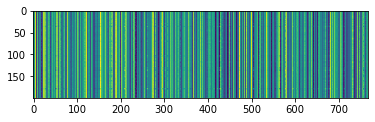

In [12]:
plt.imshow(X[0])

In [13]:
max_image_side = max([max(X[x].shape)for x in X])

In [14]:
def resize_image(image, desired_size=max_image_side):
    image = cv2.resize(image, (desired_size, desired_size), interpolation=cv2.INTER_AREA)
    return image

In [15]:
for i in range(len(X)):
    X[i] = resize_image(X[i])

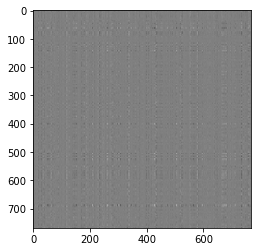

In [16]:
plt.imshow(X[0]-X[326], cmap='gray')

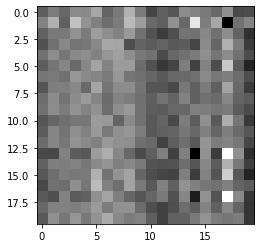

In [17]:
plt.imshow(resize_image(X[0]-X[326], 20), cmap='gray')

### Create dataset

In [18]:
class Tweets(Dataset):

    def __init__(self, X, y, transform=None):
        self.X = torch.as_tensor(X)
        self.y = torch.as_tensor(y)
        self.transforms = transform
        
    def __getitem__(self, index):

        X = self.X[index]
        y = self.y[index]

        if self.transforms:
            X = self.transforms(X)

        return X, y

    def __len__(self):
        return len(self.X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [20]:
len(X_train)

336

In [21]:
len(X_test)

84

Data augmentation by randomly swapping the order of the tweets in a profile

In [22]:
swap_random_rows = lambda x: x[torch.randperm(x.shape[0])]

In [23]:
data_aug = torchvision.transforms.Compose([
    swap_random_rows,
    ])

In [24]:
batch_size = 4
train_loader = DataLoader(Tweets(X_train, y_train, transform=data_aug), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Tweets(X_test, y_test, transform=data_aug), batch_size=batch_size, shuffle=False)

/tmp/ipykernel_20844/2507489631.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  self.X = torch.as_tensor(X)


### Create model

In [25]:
# REVISAR CAPAS POR QUE ES MUY RARO QUE FUNCIONE
class TweetSentimentModel(nn.Module):
    def __init__(self):
        super(TweetSentimentModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)
    
    def forward(self, x, training=True):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.1, training=training)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.dropout(x, p=0.1, training=training)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv5(x))
        x = F.dropout(x, p=0.1, training=training)
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv7(x))
        x = F.dropout(x, p=0.1, training=training)
        x = F.relu(self.conv8(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        #x = x.flatten()
        x = x.view(-1, 2048)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x))
        return x


In [26]:
model = TweetSentimentModel().to(device)
optimizer = AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [27]:
def one_hot_encode(y, num_classes):
    num_samples = y.shape[0]
    y_one_hot = torch.zeros((num_samples, num_classes))

    for i in range(num_samples):
        y_one_hot[i, y[i].int()-1] = 1   
    
    return y_one_hot

In [28]:
def get_accuracy(predictions, y):
    return (predictions.argmax(dim=1) == y).float().mean().item()

In [29]:
def evaluate_model(model, data_loader):
    
    model.eval()
    
    total_loss = 0
    total_accuracy = 0

    with torch.no_grad():
        for batch in data_loader:
            X, y = batch
            y = one_hot_encode(y, 2)
            predictions = model(X)
            loss = criterion(predictions, y)
            total_loss += loss.item()
            total_accuracy += get_accuracy(predictions, y)

    accuracy = total_accuracy / len(data_loader)
    loss = total_loss / len(data_loader)
    return accuracy, loss

In [30]:
num_epochs = 10

In [31]:
for epoch in range(num_epochs):
    for step, (profiles, labels) in enumerate(train_loader):
        print(len(profiles))
        print(len(labels))
        profiles = profiles.unsqueeze_(1).to(device)

        labels = labels.to(device)
        output = model(profiles)
        
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, loss: {loss}')

4
4


/tmp/ipykernel_20844/1273084969.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc5(x))


9216
9216


NameError: name 'output' is not defined

In [ ]:
evaluate_model(model, test_dataloader)